In [2]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import clear_output
%matplotlib inline

In [3]:
data = np.loadtxt("./lienard_intermittency.dat")
train = data[:, 1][:45000]
test =  data[:, 1][45000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

In [4]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [5]:
from torch.utils.data import DataLoader

In [6]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [8]:
def Asymmetric_loss(y_pred, y_true):
    y_plus = torch.abs(y_true)
    y_p_plus = torch.abs(y_pred)
    y_max = torch.maximum(y_plus, y_p_plus)
    return ((y_plus - y_max) ** 2).mean() + 3 * ((y_p_plus - y_max) ** 2).mean()

In [9]:
def run_epoch(model, dataloader, optimizer, criterion, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        x = x.float()
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous().float(), y.contiguous().float())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

In [10]:
model = LSTMModel(input_size=1, hidden_layer_size=500, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

In [11]:
def train(lr, mode, betas, epochs, num_nerons=100, criterion=Asymmetric_loss):
    model = LSTMModel(input_size=1, hidden_layer_size=num_nerons, num_layers=2, output_size=1, dropout=0.2)
    model = model.to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, eps=1e-9)

    losses_train = []
    losses_test = []
    # begin training
    for epoch in range(epochs):
        if mode:
            if epoch > epochs / 2:
                lr = 0.0001
        else:
            if epoch % 100 == 0:
                lr *= 0.9
    #     if epoch > 100:
    #         lr = 0.00001
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, eps=1e-9)    
        loss_train = run_epoch(model, train_dataloader, optimizer, criterion,  is_training=True)
        loss_val = run_epoch(model, test_dataloader, optimizer, criterion)
        losses_train.append(loss_train)
        losses_test.append(loss_val)

        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)
        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)
        plt.show()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}, mode:{}, lr: {}, betas: {}'
                  .format(epoch+1, epochs, loss_train, loss_val, mode, lr, betas))
    return model


In [12]:
def GetRmse(model):
    model.eval()
    train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

    rmse = []

    for k in range(1, 20):
        test_right_part = (len(test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            x = x.float()
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                #out = torch.abs(model(cur_x.to('cuda')))
                
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse

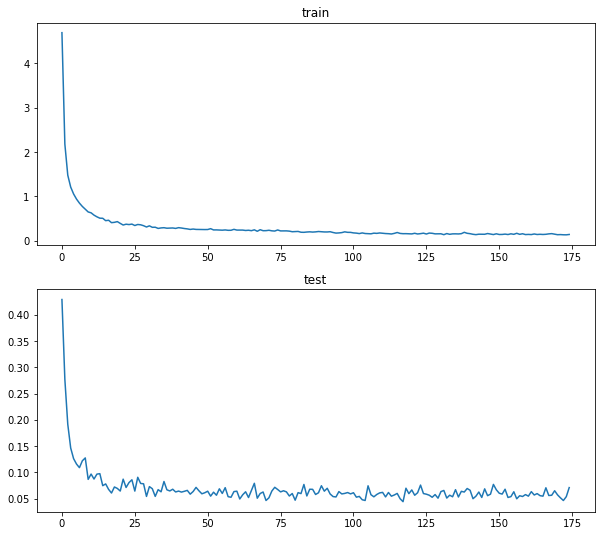

Epoch[175/175] | loss train:0.142273, test:0.071263, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [29]:
asym_model = GetRmse(train(0.001, 0, (0.9, 0.999), 175, 100, Asymmetric_loss))

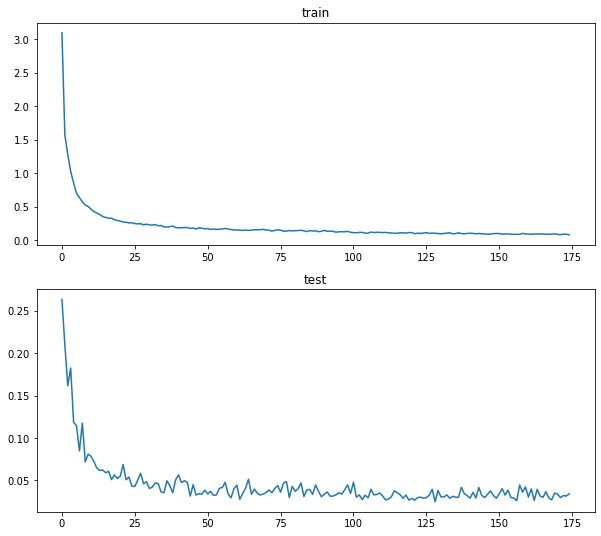

Epoch[175/175] | loss train:0.080233, test:0.034323, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [23]:
mse_model1 = train(0.001, 0, (0.9, 0.999), 175, 100, nn.MSELoss())

In [24]:
torch.save(mse_model1.state_dict(), "mse_model1Lienard")

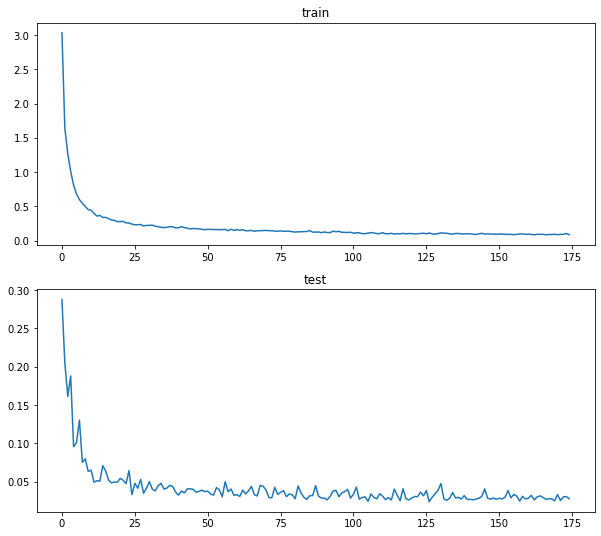

Epoch[175/175] | loss train:0.084943, test:0.027699, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [13]:
mse_model = GetRmse(train(0.001, 0, (0.9, 0.999), 175, 100, nn.MSELoss()))

In [14]:
def gevl_loss(y_pred, y_true):
    u = y_pred - y_true  
    return ((1-torch.exp(-u**2))*u**2).mean()

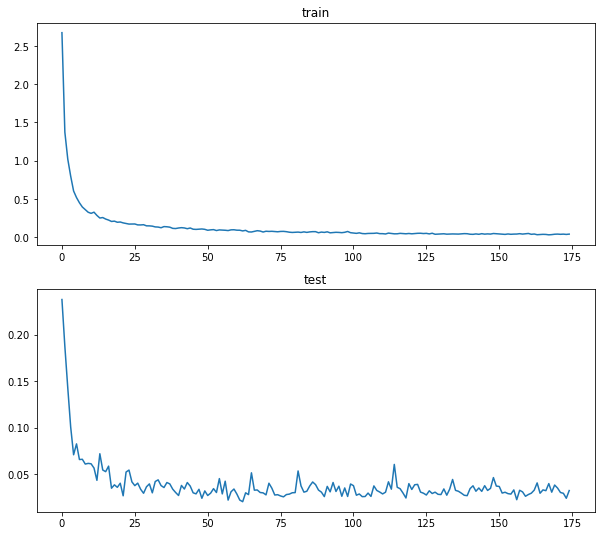

Epoch[175/175] | loss train:0.039118, test:0.032260, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [21]:
gevl_net = train(0.001, 0, (0.9, 0.999), 175, 100, gevl_loss)

In [25]:
torch.save(gevl_net.state_dict(), "gevl_netLienard")

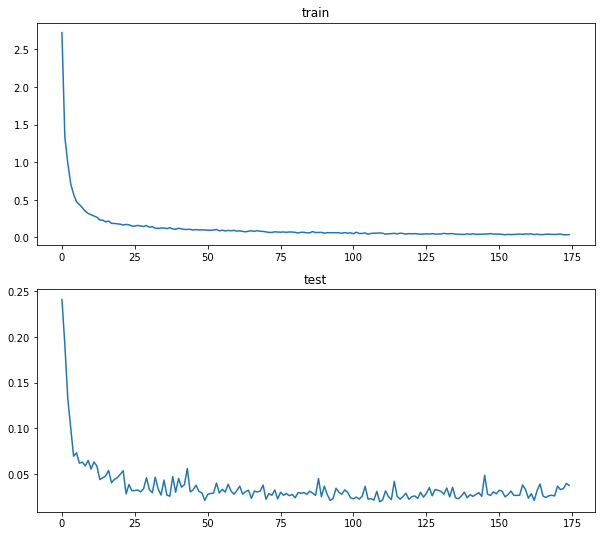

Epoch[175/175] | loss train:0.038591, test:0.037548, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [15]:
rmse_gevl_net = GetRmse(train(0.001, 0, (0.9, 0.999), 175, 100, gevl_loss))

In [16]:
def Frechet_loss(y_pred, y_true, alpha=13, s=1.7):
    u = torch.abs(y_pred - y_true)
    K = alpha/s*((u+s*(alpha/(1+alpha))**(1/alpha))/s)**(-1-alpha)
    K_exp = ((u+s*(alpha/(1+alpha))**(1/alpha))/s)**-alpha
    return (-torch.log(K) + K_exp).mean()

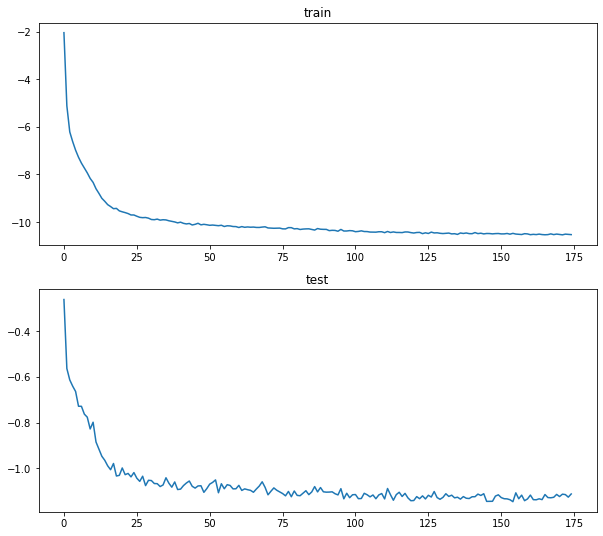

Epoch[175/175] | loss train:-10.535682, test:-1.111454, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [22]:
frechet_net = train(0.001, 0, (0.9, 0.999), 175, 100, Frechet_loss)

In [26]:
torch.save(frechet_net.state_dict(), "frechet_netLienard")

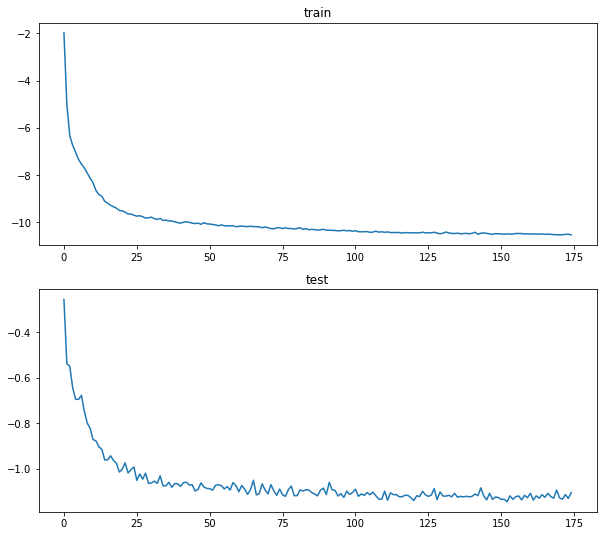

Epoch[175/175] | loss train:-10.542496, test:-1.105946, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [17]:
rmse_frechet_net = GetRmse(train(0.001, 0, (0.9, 0.999), 175, 100, Frechet_loss))

In [18]:
mse_model

[0.04426734052384474,
 0.12680595745399545,
 0.19639385275240637,
 0.27973598489392965,
 0.3111809497110485,
 0.3577725201811569,
 0.3840767241561808,
 0.3972738936096895,
 0.39929699635156524,
 0.40917980384151864,
 0.4097480854779965,
 0.4091718863033023,
 0.41087873740711545,
 0.4088530072972769,
 0.41559287273353274,
 0.40939705214175154,
 0.42236054993569644,
 0.4260478886670721,
 0.4523698161328286]

In [19]:
rmse_frechet_net

[0.04633942542608153,
 0.13532417034087754,
 0.19259631487086745,
 0.2733445106509408,
 0.33223128923372003,
 0.3596011024459786,
 0.39635163690510494,
 0.42160750491521654,
 0.4328675574555373,
 0.4432085805981192,
 0.4531309127328117,
 0.4449983741407085,
 0.4516223924886808,
 0.45521176190621854,
 0.45163817721031646,
 0.4769086589957748,
 0.4711942915798748,
 0.5029309334523037,
 0.48857042158405034]

In [20]:
rmse_gevl_net

[0.05802842439719806,
 0.1617111925485926,
 0.24719676787223058,
 0.3143934293283314,
 0.339620985571749,
 0.394338733089367,
 0.404368627611776,
 0.44443046288729926,
 0.4441116951313905,
 0.4540424704176692,
 0.4403435237654154,
 0.4406568187415638,
 0.4428080355130962,
 0.43861644459494625,
 0.4425740523987361,
 0.44610131134246994,
 0.453579264455594,
 0.4486103665797466,
 0.4404606362154685]

Text(0.5, 0, 'prediction step')

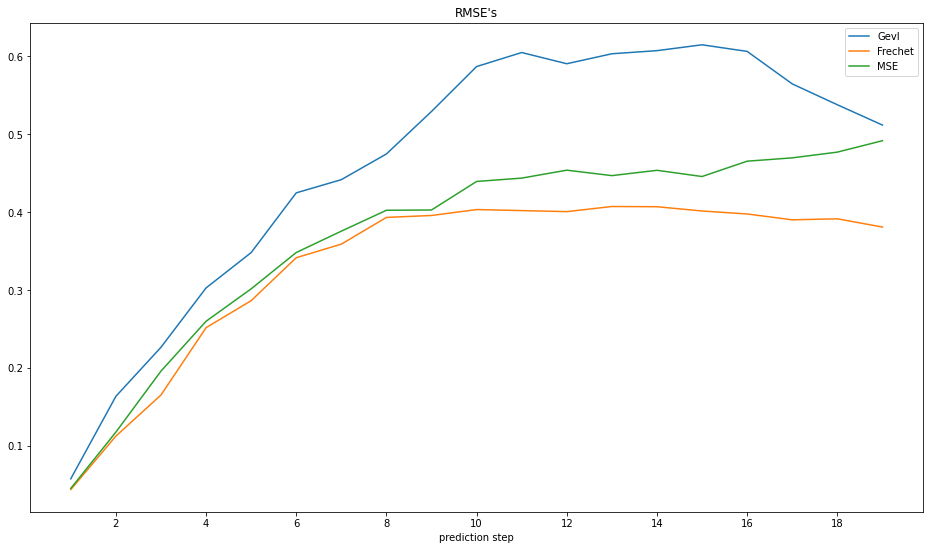

In [63]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_gevl_net, label="Gevl")
ax.plot(list(range(1, 20)), rmse_frechet_net, label="Frechet")
ax.plot(list(range(1, 20)), mse_model, label="MSE")
#ax.plot(list(range(1, 20)), rmse, label="Asymmetric")
ax.legend()
ax.set_title("RMSE's")
ax.set_xlabel("prediction step")

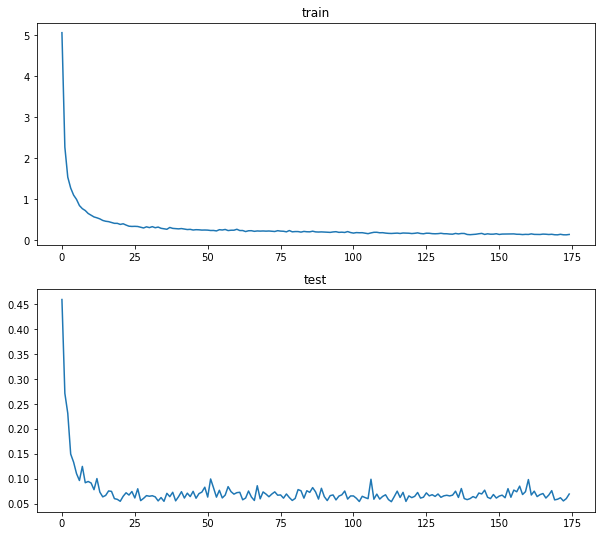

Epoch[175/175] | loss train:0.140913, test:0.069398, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [44]:
asymm_model = train(0.001, 0, (0.9, 0.999), 175, 100, Asymmetric_loss)

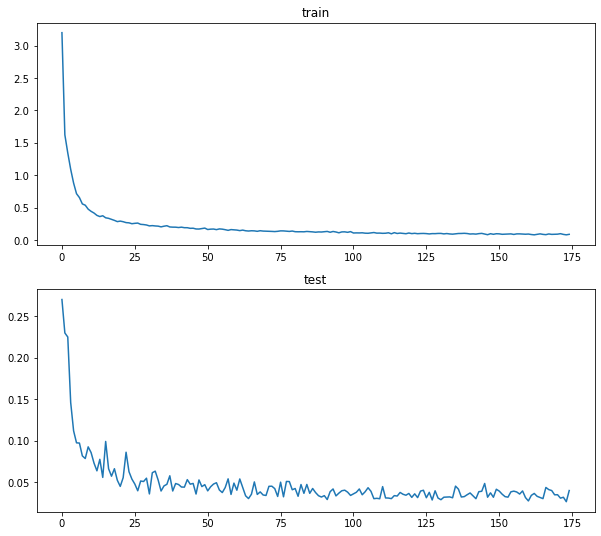

Epoch[175/175] | loss train:0.086757, test:0.039521, mode:0, lr: 0.0008100000000000001, betas: (0.9, 0.999)


In [64]:
MSE_model = train(0.001, 0, (0.9, 0.999), 175, 100, nn.MSELoss())

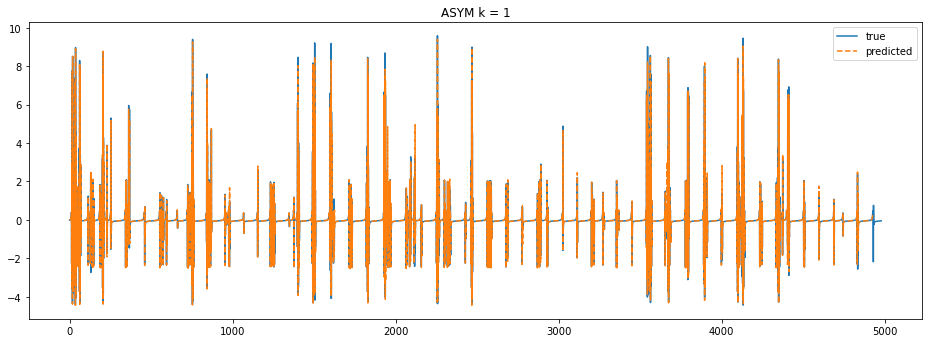

In [69]:
ShowPredict(MSE_model, 1)

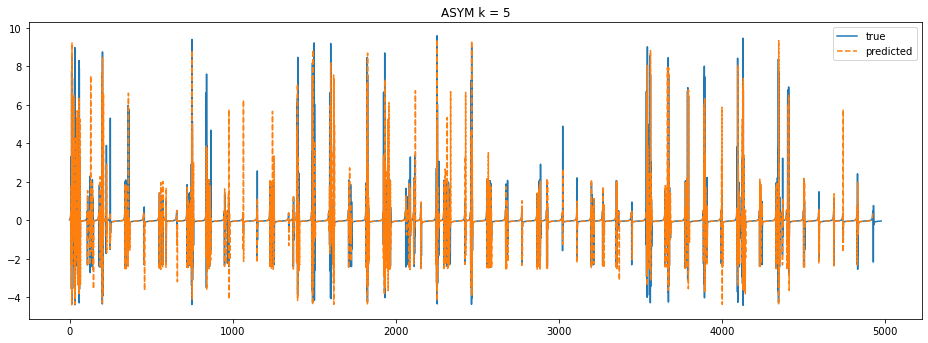

In [68]:
ShowPredict(MSE_model, 5)

In [60]:
rmse = GetRmse(asymm_model)

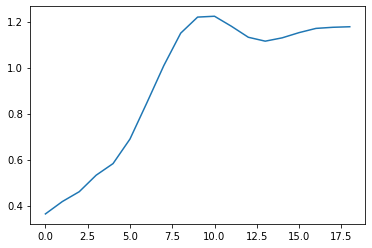

In [61]:
plt.plot(rmse)

In [66]:
def ShowPredict(model, k):
    train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    test_right_part = (len(test)- 20)%64
    predicted_val = np.array([])
    for idx, (x, y) in enumerate(val_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        x = x.float()
        cur_x = x
        for _ in range(k):
            out = model(cur_x.to('cuda'))
            #out = torch.abs(model(cur_x.to('cuda')))
            
            cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
        predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
        
    
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1.plot(test_norm[20+k-1:], label='true')
    if k == 1:
        ax_1.plot(predicted_val[:],  linestyle = '--', label='predicted')
    else:
        ax_1.plot(predicted_val[:-k+1],  linestyle = '--', label='predicted')
    ax_1.set_title("ASYM k = {0}".format(k))
    ax_1.legend()
    
    plt.show()

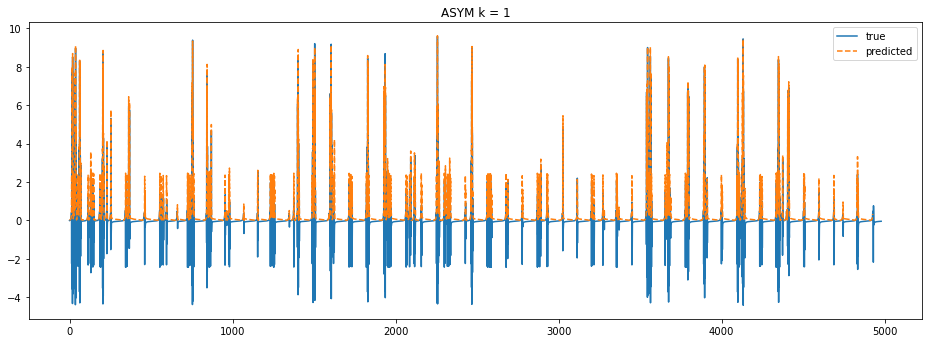

In [56]:
ShowPredict(asymm_model, 1)

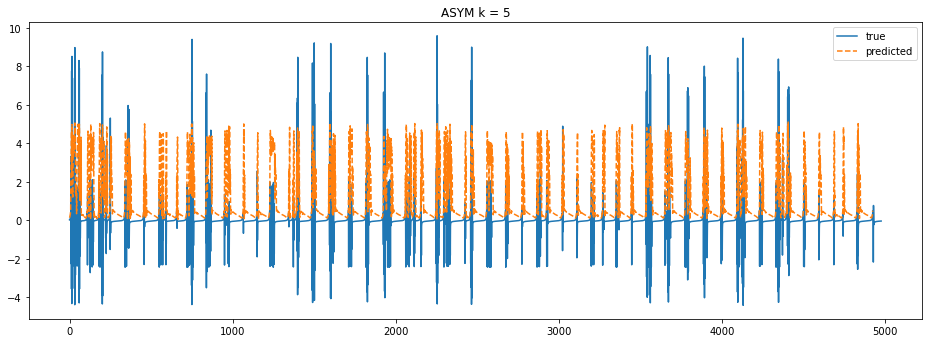

In [57]:
ShowPredict(asymm_model, 5)

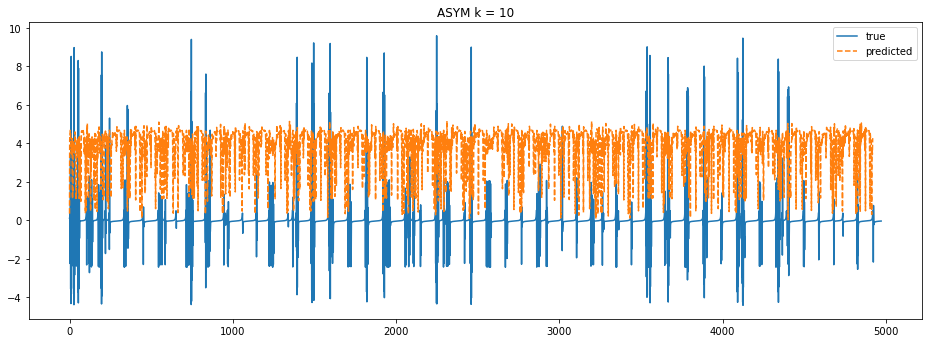

In [58]:
ShowPredict(asymm_model, 10)